# Recurrent Neural Networks

Alípio Jorge

May 2021

# RNN

- Recurrent Neural Networks
  - good for **sequential data**
    - is it going to rain tomorrow?
    - how do you finish this .... ?
    - "estou bem" is a translation for "I am OK"
    - I play a few notes and the RNN improvises
  - the output value depends on the input but also on previous inputs


# RNN unit

- Simplest RNN (one neuron = one unit)
  - the output at time $t$ is influenced by the output at time $t-1$
  - $y_t = \sigma(w_0 + x_t.w_1 +y_{t-1}.w_2)$


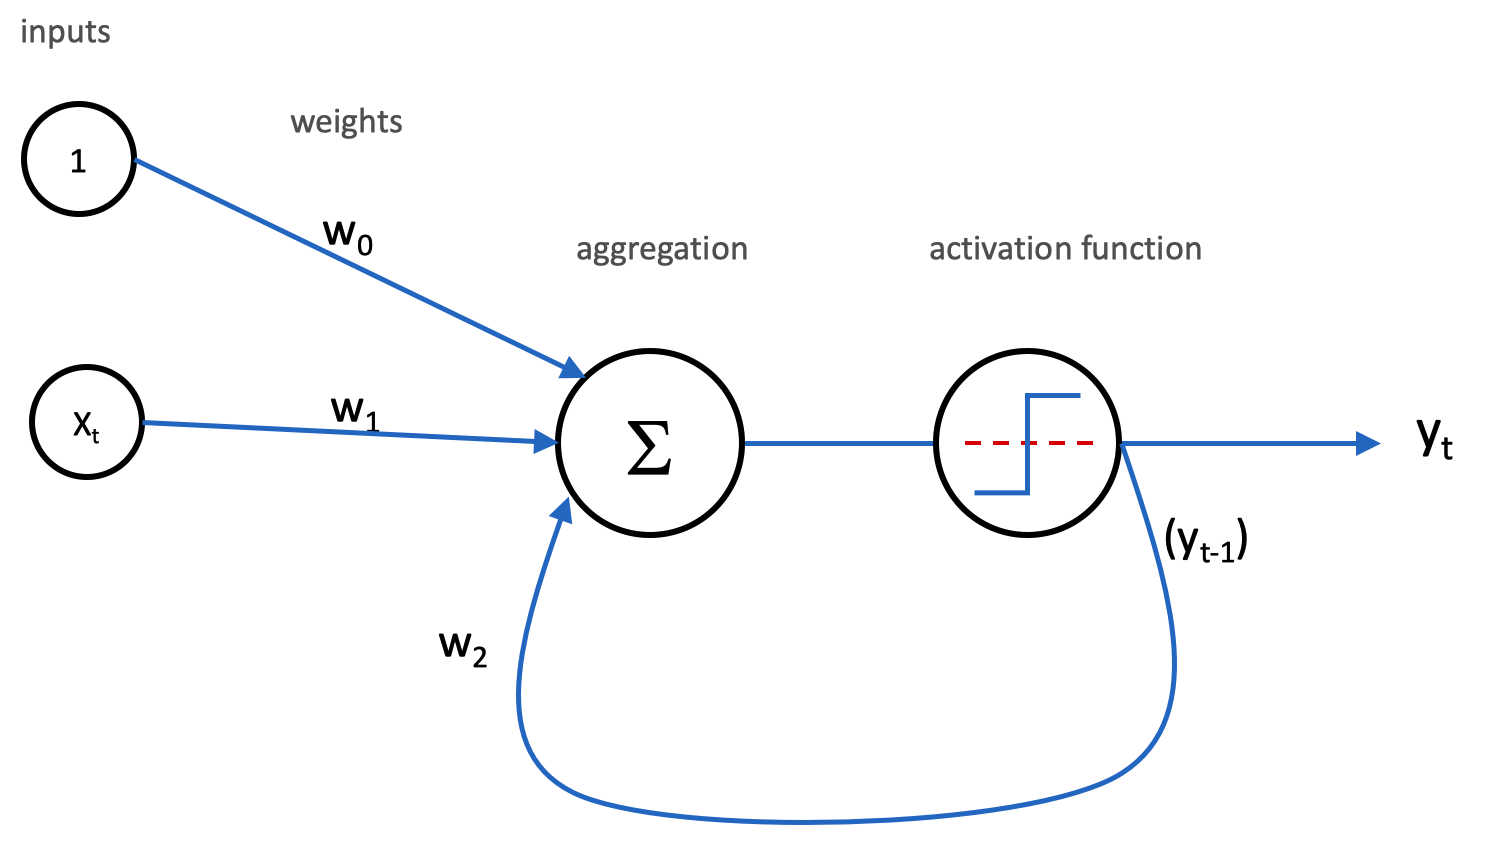

In [69]:
from IPython.display import Image
Image("imagens/13-RNN-simplest-rnn.png")

# RNN layer

- Generic RNN layer
  - Each unit in the layer "sends" and "receives" recurrent conncections
  - the output of the hidden recurrent layer at time $t$ is influenced by the output at time $t-1$
  
  
  $$R_{(t)} = \sigma(W_b + X_{(t)}.W_x + R_{(t-1)}.W_r)$$
  

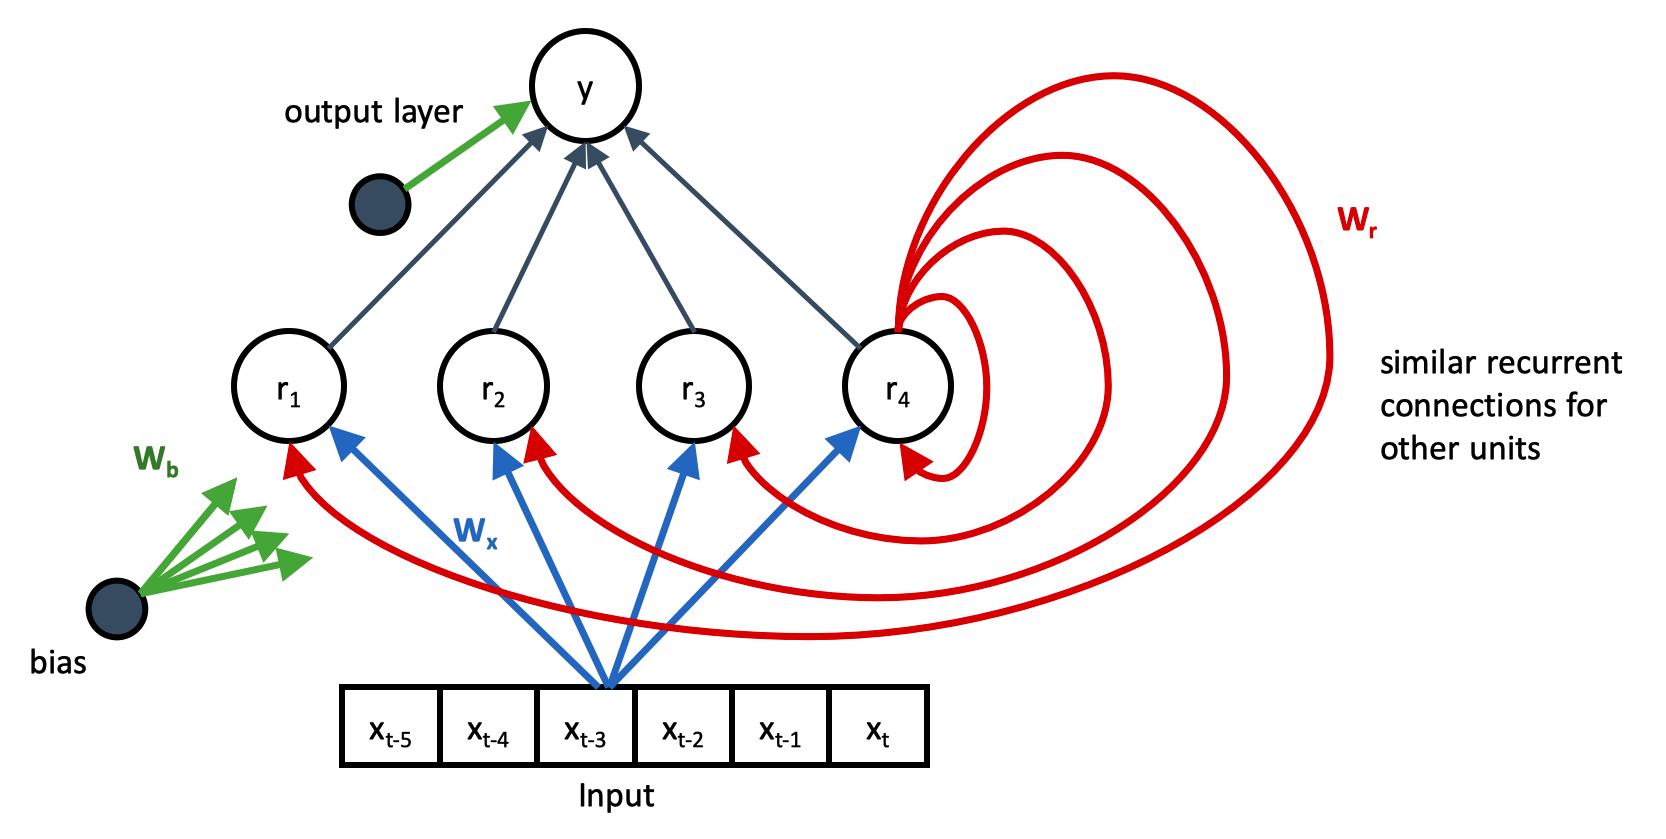

In [71]:
from IPython.display import Image
Image("imagens/13-RNN-layer.png")

# Example > binary sequence

- Binary artificial sequences
    - Test the ability to predict **next in sequence**
    - Different degrees of **difficulty**
    - Tasks that require **memory**

In [153]:
import pandas as pd
import numpy as np

art1 = np.tile([0,1],1000)
art2 = np.tile([0,0,0,1],1000)
art3 = np.tile([0,0,0,0,0,0,0,0,0,1],1000)
art4 = np.tile([0,0,0,1,0,1,1,0,1,0],1000)
art5 = np.tile([0,0,0,1,0,1,1,0,1,0,0,1,1,1,0,0,0,1,0,1],1000)

# Turning a sequence into a set of examples

- In Machine Learning we tend to segment data into **examples** or **cases**


- A sequence can be segmented using a **sliding window**


- Each case usually overlaps its neighbours
  - Note the similarity with the kernel in CNNs


- For each case:
    - `X` the values observed in the window
    - `y` is the next value

In [156]:
def prep_data(data, max_len=10, stride=1, lahead=1):
    start_indexes = np.arange(0, len(data) - (max_len + lahead), step = stride)
    data_matrix = np.zeros(shape=(len(start_indexes),max_len+1))
    
    for i in range(len(start_indexes)):
        xpart=data[start_indexes[i]:(start_indexes[i]+max_len)]
        ypart=data[start_indexes[i]+max_len+lahead]
        data_matrix[i,] = np.hstack((xpart,ypart))
 
    # remove rows with at least one NaN
    data_matrix = data_matrix[~np.isnan(data_matrix).any(axis=1)]
    
    return data_matrix[:,:-1],data_matrix[:,-1]
   
prep_data(art1,max_len=10)

(array([[0., 1., 0., ..., 1., 0., 1.],
        [1., 0., 1., ..., 0., 1., 0.],
        [0., 1., 0., ..., 1., 0., 1.],
        ...,
        [0., 1., 0., ..., 1., 0., 1.],
        [1., 0., 1., ..., 0., 1., 0.],
        [0., 1., 0., ..., 1., 0., 1.]]),
 array([1., 0., 1., ..., 1., 0., 1.]))

# Load the layers

- And other utilities

In [42]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.layers import GRU
from keras.utils import np_utils

import matplotlib.pyplot as plt

# Prepare the data

- Choose the artificial dataset to use


- Define the **window size**
    - long windows give more information
    
    
- Divide in train, validation and test


- Reshape as tensors
    - MLP will use **flat** versions
    - RNN will use **tensor** versions

In [157]:
def data_setup(data=art1,window=5):

    ldata=len(data)

    dataf = data[0:int(ldata*0.8)]
    datav = data[int(ldata*0.8):int(ldata*0.9)]
    datat = data[int(ldata*0.9):ldata]

    Xflatf,yf = prep_data(dataf, max_len=window, lahead=1)
    Xflatv,yv = prep_data(datav, max_len=window, lahead=1)
    Xflatt,yt = prep_data(datat, max_len=window, lahead=1)

    Xf = np.reshape(Xflatf, (Xflatf.shape[0], 1, Xflatf.shape[1]))
    Xv = np.reshape(Xflatv, (Xflatv.shape[0], 1, Xflatv.shape[1]))
    Xt = np.reshape(Xflatt, (Xflatt.shape[0], 1, Xflatt.shape[1]))
    
    return Xflatf,Xf,yf,Xflatv,Xv,yv,Xflatt,Xt,yt

# Learning hyperparameters


In [158]:
n_units = 4
batch_size = 1
total_epochs = 5

# Some experiments

- Test MLP and RNN with different problems
    - `window=5`
    - `n_units=4`


- Start with the MLP for a baseline


- Results with MLP
    - art1 gives unstable results
        - accuracy ≈ 1.0 or 0.5 
    - art2 is easy
        - accuracy ≈ 1.0
    - art3 harder
        - accuracy ≈ 0.9
    - art4 is even harder
        - accuracy ≈ 0.6
    - art5 is slightly harder
        - accuracy ≈ 0.55


In [159]:
window=5
Xflatf,Xf,yf,Xflatv,Xv,yv,Xflatt,Xt,yt = data_setup(art1,window)

model_mlp = Sequential()

model_mlp.add(Dense(units = n_units, input_dim = window))
model_mlp.add(Dense(units = 1)) 

model_mlp.compile(loss = 'binary_crossentropy', 
                  optimizer = 'RMSprop', 
                  metrics = ['accuracy'])
  
history = model_mlp.fit(Xflatf,yf,
  batch_size = batch_size, 
  epochs = total_epochs,
  validation_data=(Xflatv,yv)
)

print("MLP Accuracy =",model_mlp.evaluate(Xflatt,yt)[1])

Epoch 1/5
1594/1594 [==============================] - 4s 2ms/step - loss: 7.4085 - accuracy: 0.5197 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 2/5
1594/1594 [==============================] - 2s 1ms/step - loss: 7.0894 - accuracy: 0.5404 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 3/5
1594/1594 [==============================] - 2s 1ms/step - loss: 7.5124 - accuracy: 0.5130 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 4/5
1594/1594 [==============================] - 2s 1ms/step - loss: 8.1654 - accuracy: 0.4706 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 5/5
7/7 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000
MLP Accuracy = 0.5


# RNN

- `SimpleRNN` is the simplest version of RNN
    - Next we will see **LSTM** and **GRU**

# Some experiments > RNN

- Test MLP and RNN with different problems
    - `window=5`
    - `n_units=4`


- Try now RNN
    - Different runs may give very different results


- Results with RNN
    - art1 is easy
        - it may fail in some runs though
    - art2
        - accuracy ≈ 0.75 (MLP is better)
    - art3 
        - accuracy ≈ 0.9 (similar to MLP)
    - art4
        - accuracy ≈ 0.8 (RNN tends to be better)
    - art5 is slightly harder
        - accuracy ≈ 0.7 (RNN tends to be better)


In [160]:
window=5
Xflatf,Xf,yf,Xflatv,Xv,yv,Xflatt,Xt,yt = data_setup(art1,window)

model_rnn = Sequential()

model_rnn.add(SimpleRNN(units = n_units, input_shape = (1,window)))
model_rnn.add(Dense(units = 1)) 

model_rnn.compile(loss = 'binary_crossentropy', 
                  optimizer = 'RMSprop', 
                  metrics = ['accuracy'])
  
history = model_rnn.fit(Xf,yf,
  batch_size = batch_size, 
  epochs = total_epochs,
  validation_data=(Xv,yv)
)

print("RNN Accuracy =",model_rnn.evaluate(Xt,yt)[1])

Epoch 1/5
1594/1594 [==============================] - 8s 2ms/step - loss: 0.1452 - accuracy: 0.9104 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/5
1594/1594 [==============================] - 2s 2ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/5
1594/1594 [==============================] - 4s 3ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/5
1594/1594 [==============================] - 3s 2ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - loss: 0.0000e+00  - ETA: 1s
Epoch 5/5
7/7 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 1.0000
RNN Accuracy = 1.0


# Training RNNs

- The **backpropagation** strategy is **adapted** as **BPTT**
- Remember the back propagation algorithm
  - **Predict the output** for the inputs using the current weights
  - **Compute the errors** for the output node(s) given the true values
  - **Back propagate (distribute) these errors** to the hidden layer (weights are important)
  - Both sets of errors are used to compute the gradients for the updates
  - This can be efficiently computed 


# Training RNNs

- To derive the update expressions (single output regression):
  - minimize the cost function $R(\alpha, \beta)$
  - find derivatives  of $R$ w.r.t. $\alpha$ and $\beta$
 
- The update rules obtained:

$$ \beta_{km}^{(r+1)}=\beta_{km}^{(r)} - \gamma_r \sum_{i=1}^N \frac{\partial R_i}{\partial \beta_{km}^{(r)}} $$
$$ \alpha_{ml}^{(r+1)}=\alpha_{ml}^{(r)} - \gamma_r \sum_{i=1}^N \frac{\partial R_i}{\partial \alpha_{ml}^{(r)}} $$
$\gamma$ is the **learning rate**


# Training RNNs

- RNNs are trained with the **BPTT** strategy
  - Backpropagation through time
- weights are updated backwards
  - in the layers
  - in time


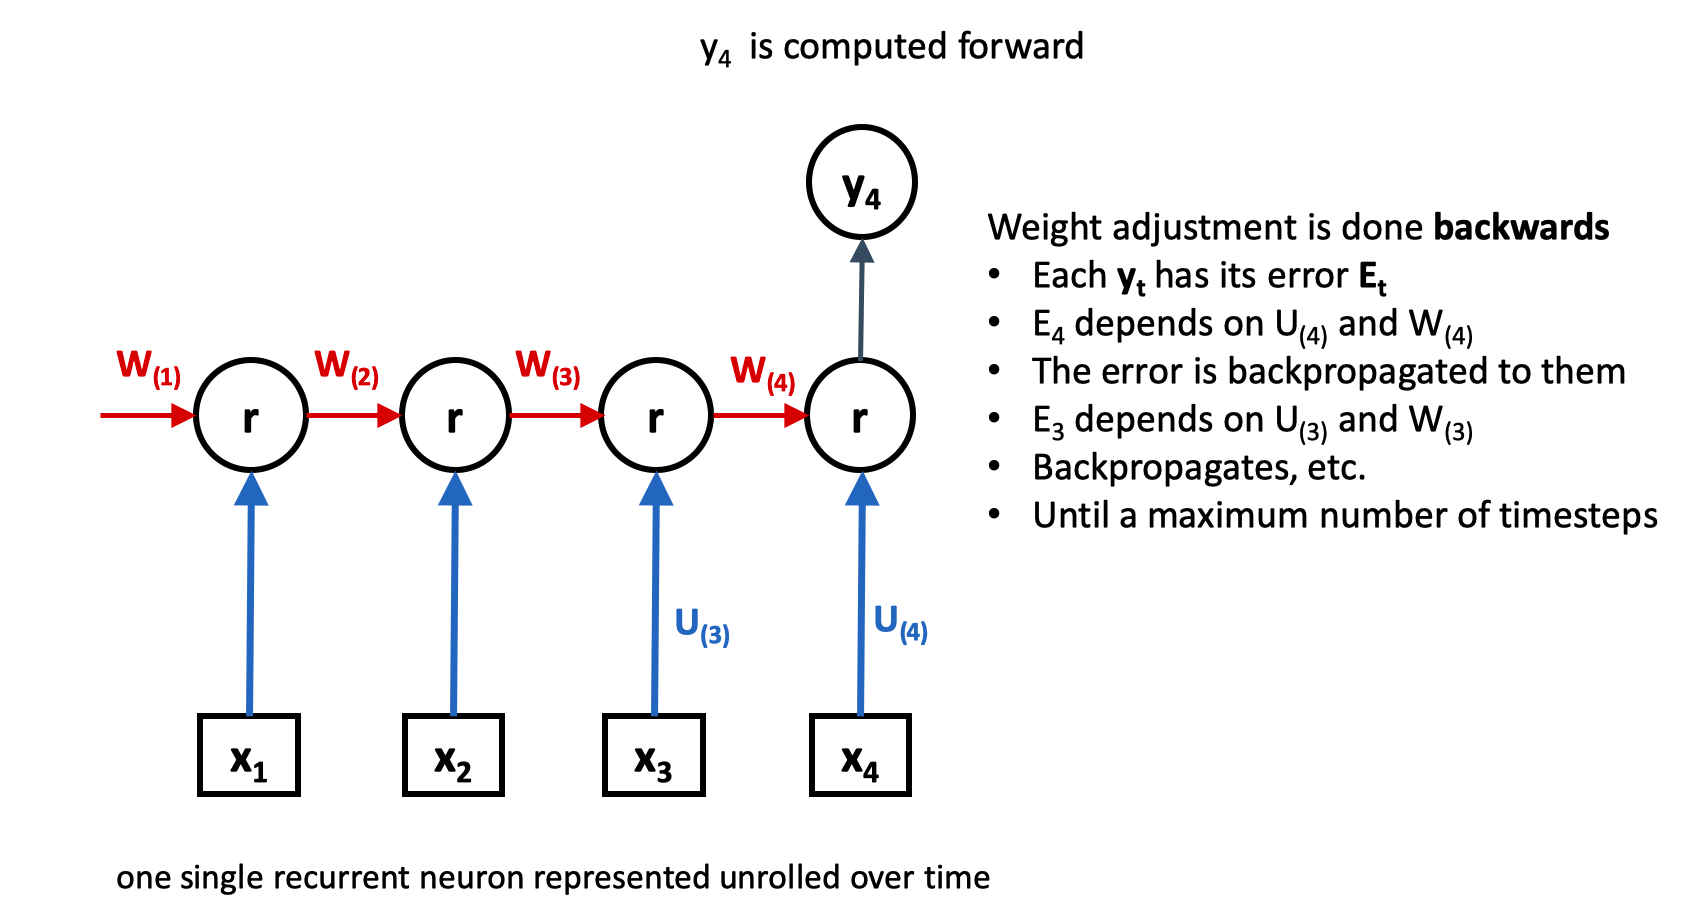

In [127]:
from IPython.display import Image
Image("imagens/13-RNN-BPTT.png")

# Training RNNs

- BPTT is backpropagation on the **unrolled network**
  - The unrolled net is as deep as the window size
  - Too many temporal layers cause **computational problems**
  - To calculate the gradient we have a long chain rule
  
  
- **Truncated BPTT**
  - limits the number of temporal layers
  - simplifies calculation of gradients
  

# Problems with the learning process

- A large number of layers can lead to **extreme gradient values**
  - Zero: **vanishing** gradient
  - Infinity (NaN in practice): **exploding** gradient
  
  
- Exploding gradient problems
  - search goes totally off-road (and takes time to come back)
  - NaN make the program crash
  - advantage: they are **easier to detect** (sudden deterioration)
  - simple solution: **clipping**

# Problems with the learning process

- Vanishing Gradient problems
  - backpropagation does not go very deep
  - **long range dependencies** are not learned
  - harder to detect (the learning task may be hard)
  - solutions:
    - ReLU activation function may help
      - it does not **saturate**
      - **activity** try the examples with the `relu`
    - LSTMs and GRUs


# Other types of data

- Non-binary symbolic sequences
  - We have binary sequences represented by 0s and 1s
  - Multi-valued symbols can be represented using one-hot encoding
    - or integers
- Multi feature sequences
  - We have a sequence of vectors instead of a sequence of values
  - Example: **word embeddings** to represent sequence of words


# More on RNNs

- statefulness
  - maintain the hidden states between batches
  - speeds up learning
  - requires special cares:
    - no data shuffling
    - batch should correspond to the period of the data
- dropout
  - can also be used
- LSTM
- GRU


# LSTM

- Example
  - *I lived in France all of my life. I moved to Portugal recently. I am starting to learn Portuguese. I speak fluent ...*


- Recurrent Neural Networks 
  - **in theory** they can learn long term dependencies in a sequence
  - in other words: they can **remember** past events
  
  
  
- However
  - they often have the **vanishing gradient** problem
  - disables long term memory
  - short memory makes som problems hard to learn


# LSTM

- LSTM
  - **Long Short Term Memory** networks
  - Initially proposed in 1997 (Hochreiter and Schmidhüber)
  - are a refinement of RNNs
  - have a **cell state**
  - use **gates**
  - are more robust in learning **long term dependencies**


- How does it predict?


# LSTM

- Compicated internal architecture


- The **cell** state
  - the top horizontal line
  - changes slowly
  - keeps overall perspective
  
  
- The **gates**
  - are soft switches
    - sigmoid puts them in [0,1]
    - if 0 they block the value
    - if 1 they leave it intouched


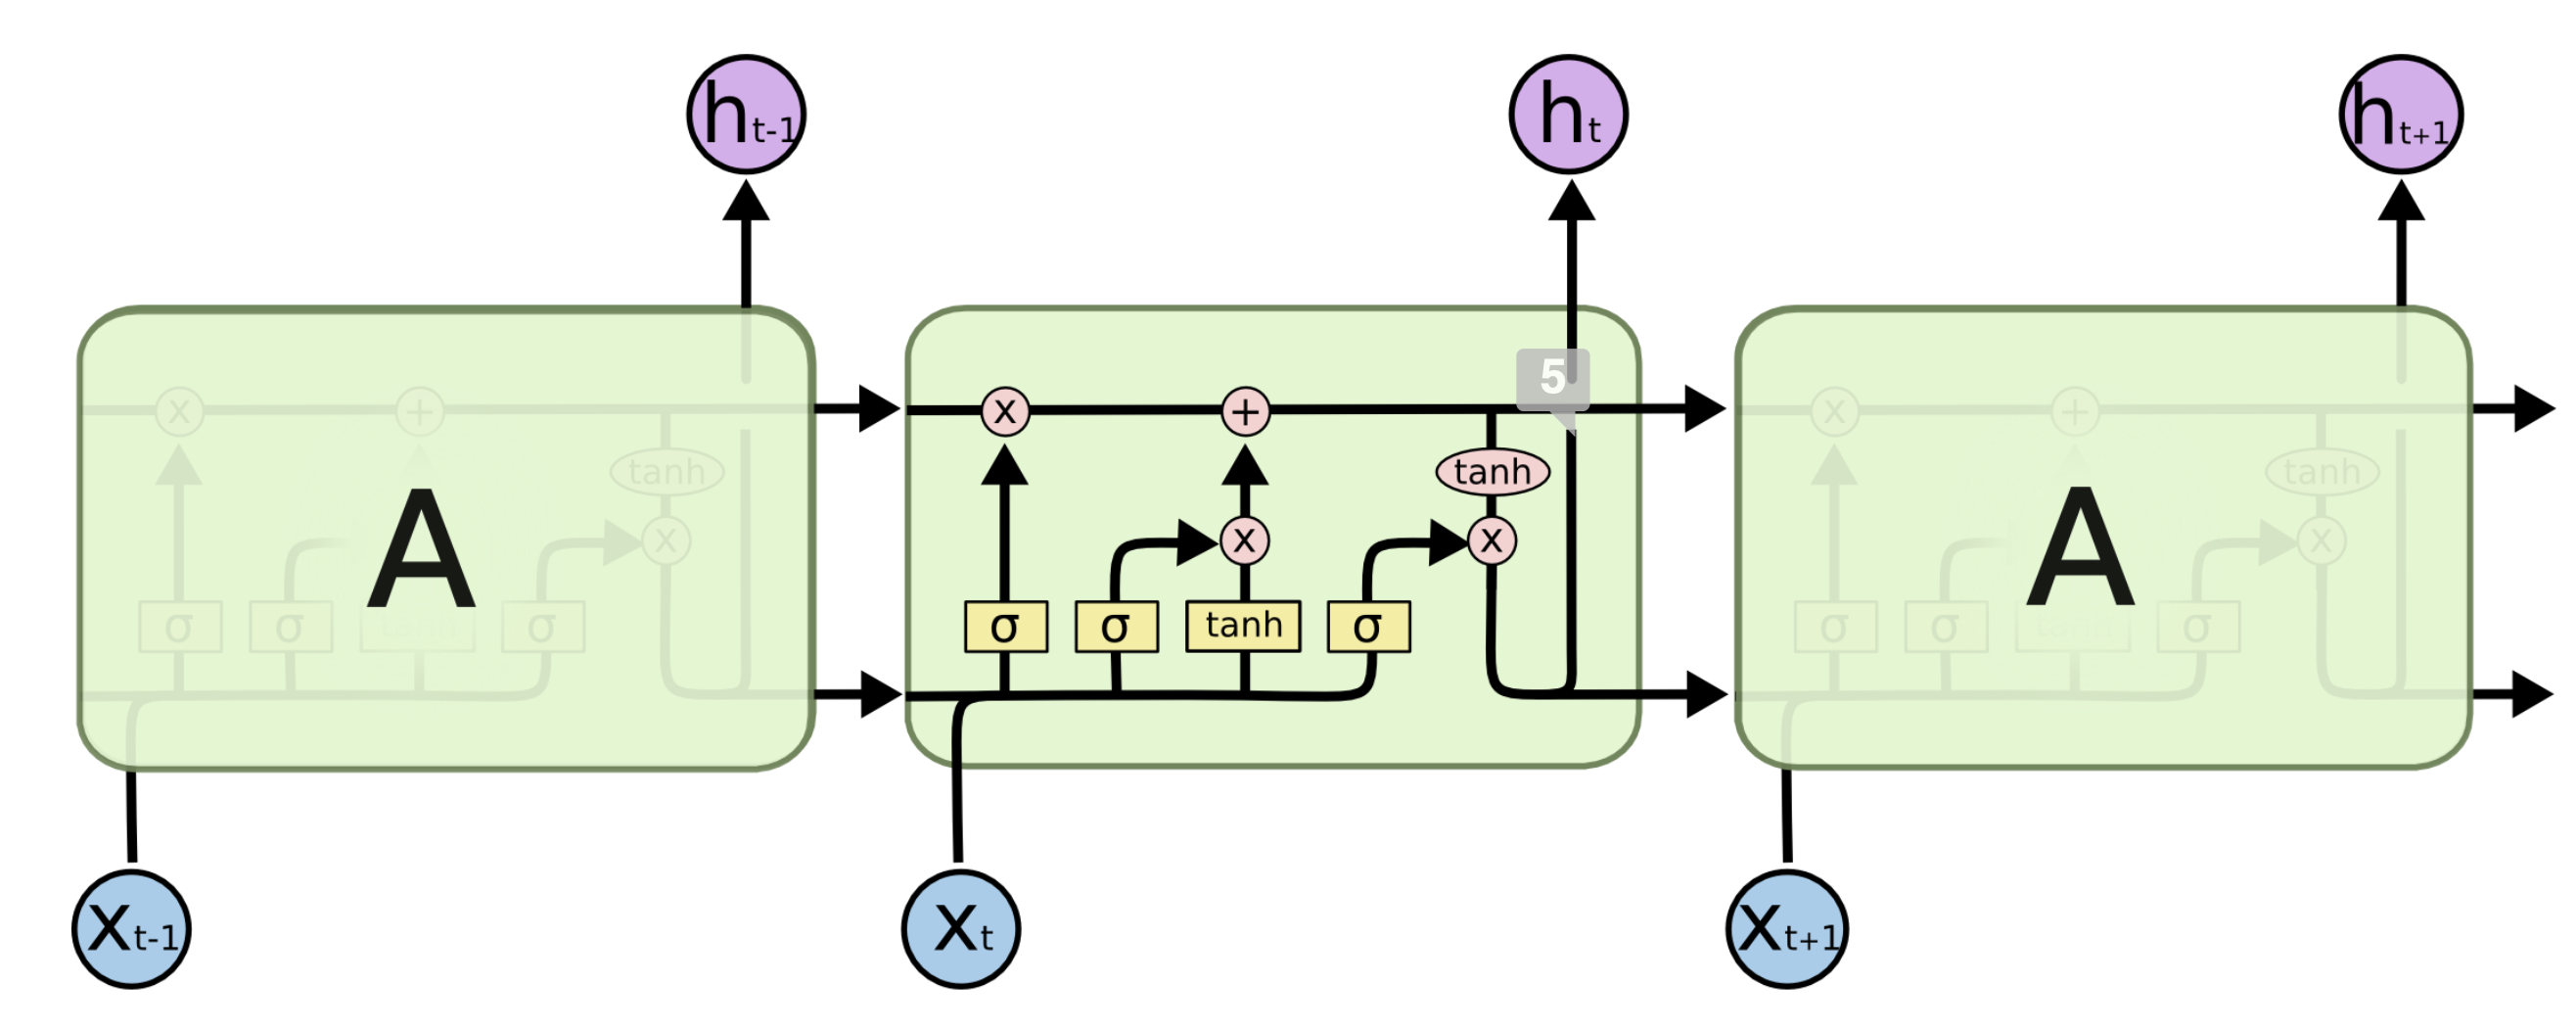

In [129]:
from IPython.display import Image
Image("imagens/14-LSTM-Unit.png")

# LSTM

- The **forget** gate $f_t$
  - leftmost
  - combines $x_t$ and $h_{t-1}$ 
  - modulates the signal in the cell state
  $$f_t = \sigma(W_f.[h_{t-1},x_t] + b_f)$$
  
  
  
- Example
  - classifying reviews as positive or negative
  - "amazing! I got there soon and the place was full. Eventually I got a place"
  - The word amazing is important > the forget gate could **block** all other words but this one
  - the gate is activated by weights that are learned in training


# LSTM

- The **input** gate $i_t$
  - next sigmoid
  - looks at $x_t$ and $h_{t-1}$ 
  - it is 1 if the new information should be kept
  
  
- The **candidate** new value $\widetilde{C}_{t}$
  - applies a tanh to $x_t$ and $h_{t-1}$ 
  - is modulated by the input gate
  $$i_t = \sigma(W_i.[h_{t-1},x_t] + b_i)$$
  $$\widetilde{C}_{t} = tanh(W_C.[h_{t-1},x_t] + b_C)$$


# LSTM

- The **output** $h_t$
  - is modulated by the **output** gate $o_t$
  $$ o_t = \sigma(W_o.[h_{t-1},x_t] + b_o)$$
  $$ h_t = o_t \times tanh(C_t)$$
  


# LSTM

- This is quite a complicated architecture
  - achieves better results than RNN
    - in more complicated problems
  - in simpler sequences it is not easy to see the advantage


- There are many many LSTM variants



# The binary sequence example with LSTM

- Are the binary sequences successfully modeled?
    - `window=5`, `n_units=4`
    - art1: can fail miserably
    - art2: accuracy=1
    - art3: 0.9
    - art4: 0.6 (RNN tends to be better)
    - art5: 0.95 (better than RNN)
    
- Wider window
    - `window=10`, `n_units=4`
    - art1: does not help
    - art2: 1.0 (sometimes)
    - art3: 1.0 (improves)
    - art4: 1.0 (improves, should try RNN and MLP with this window size)
    - art5: 0.95 (does not improve)
    
    
- Activity
    - Different number of units


In [162]:
window=5
Xflatf,Xf,yf,Xflatv,Xv,yv,Xflatt,Xt,yt = data_setup(art4,window)

model_lstm = Sequential()

model_lstm.add(LSTM(units = rnn_units, input_shape = (1,window)))
model_lstm.add(Dense(units = 1)) 

model_lstm.compile(loss = 'binary_crossentropy', 
                  optimizer = 'RMSprop', 
                  metrics = ['accuracy'])

history = model_lstm.fit(Xf,yf,
  batch_size = batch_size, 
  epochs = total_epochs,
  validation_data=(Xv,yv)
)

print("LSTM Accuracy =",model_lstm.evaluate(Xt,yt)[1])

Epoch 1/5
7994/7994 [==============================] - 19s 2ms/step - loss: 0.7664 - accuracy: 0.8542 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/5
7994/7994 [==============================] - 18s 2ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/5
7994/7994 [==============================] - 19s 2ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/5
7994/7994 [==============================] - 24s 3ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/5
32/32 [==============================] - 1s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
LSTM Accuracy = 1.0


# GRU

- **Gated Recurrent Units**
  - introduced by Cho, et al. in 2014
  - appeared later
  
  
- **Simpler** than LSTMs
  - forget and input gates are combined
    - $z_t$ is the update gate
      - how much information passes
    - $r_t$ is the reset gate
      - how much past information is forgotten
  - merges the cell state and hidden state
  - often obtain better results


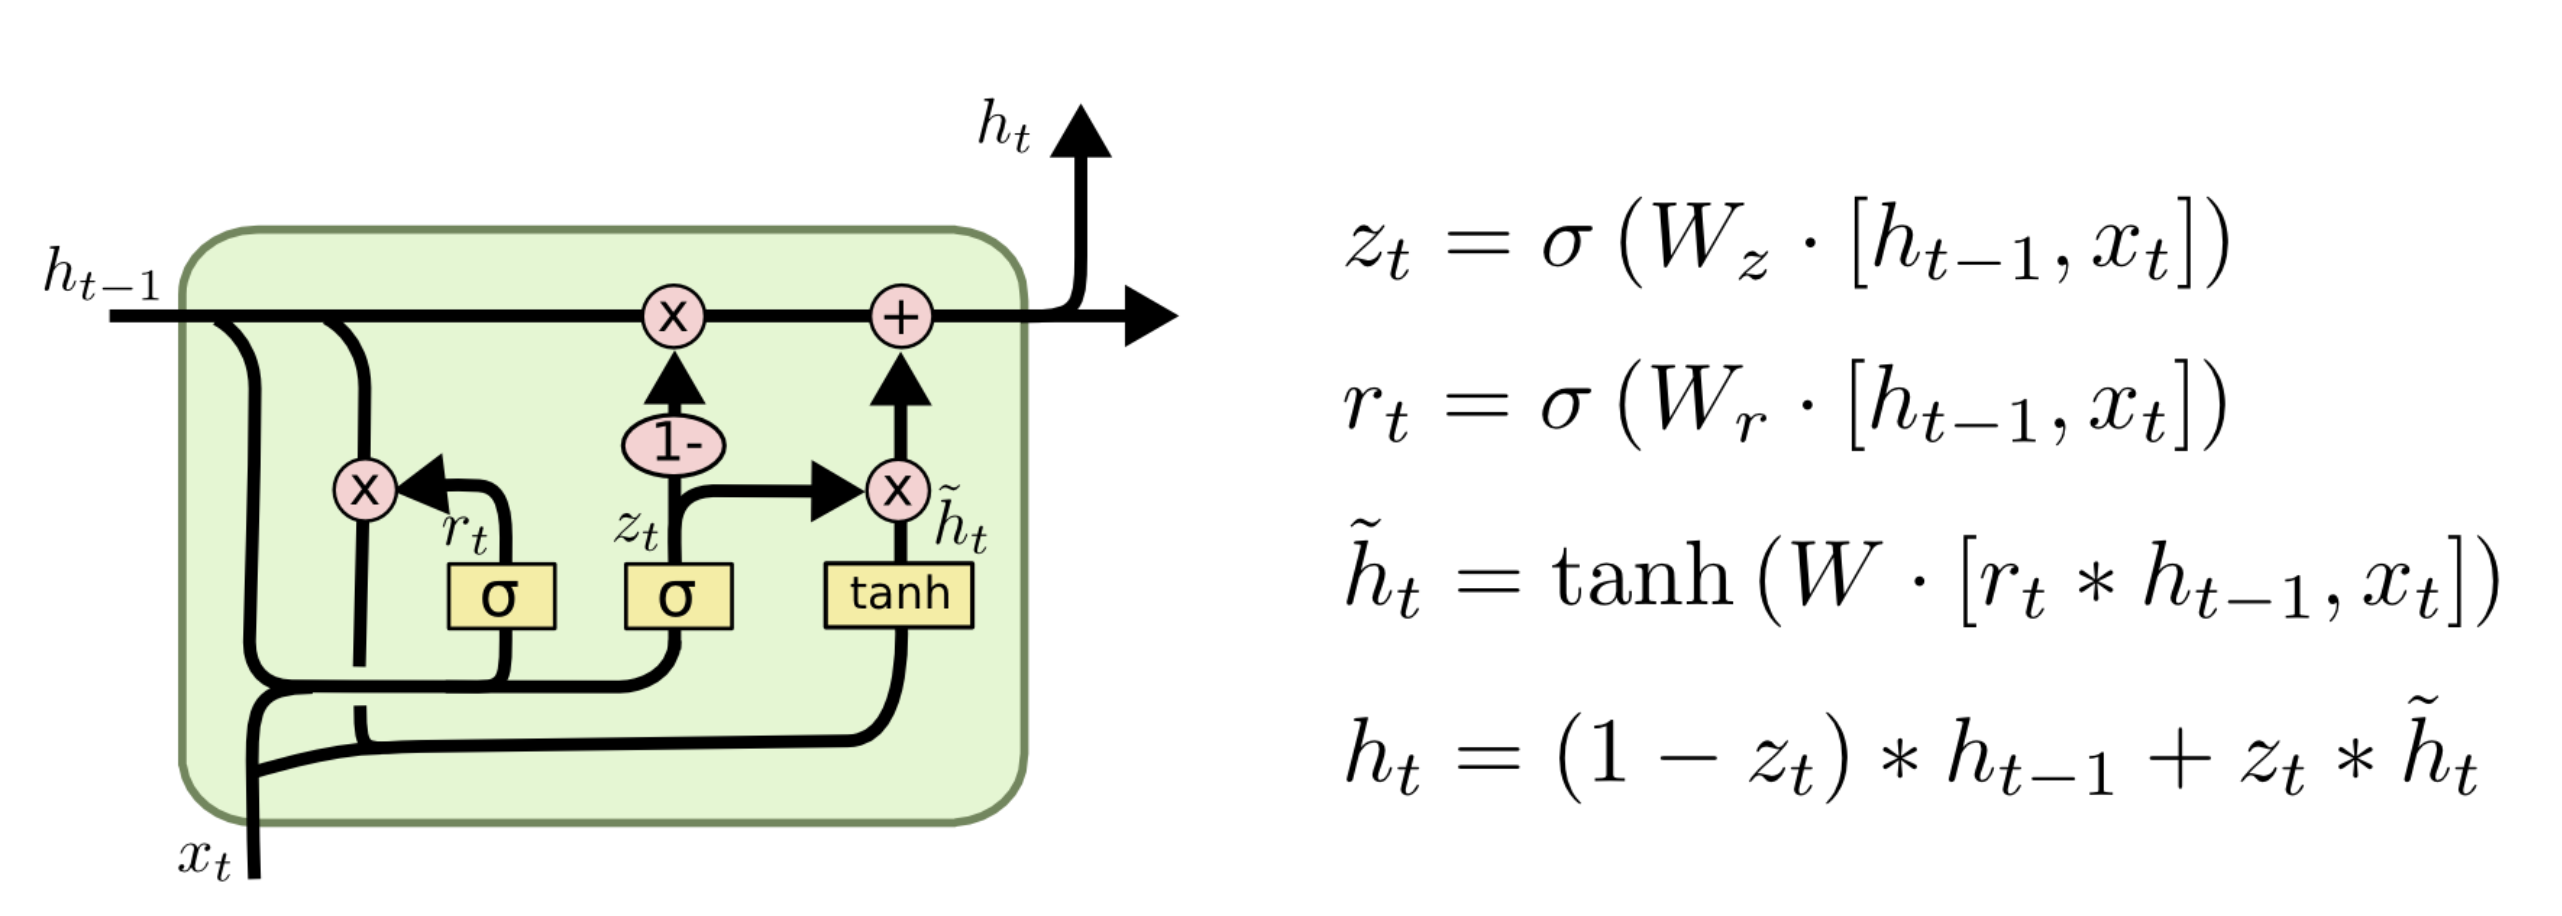

In [144]:
from IPython.display import Image
Image("imagens/14-GRU-Unit.png")

# Empirical study by Jozefowicz et al.

- Jozefowicz et al. compared a great number of RNNs, LSTMs and GRU
  - Three tasks
  - GRU were more successful


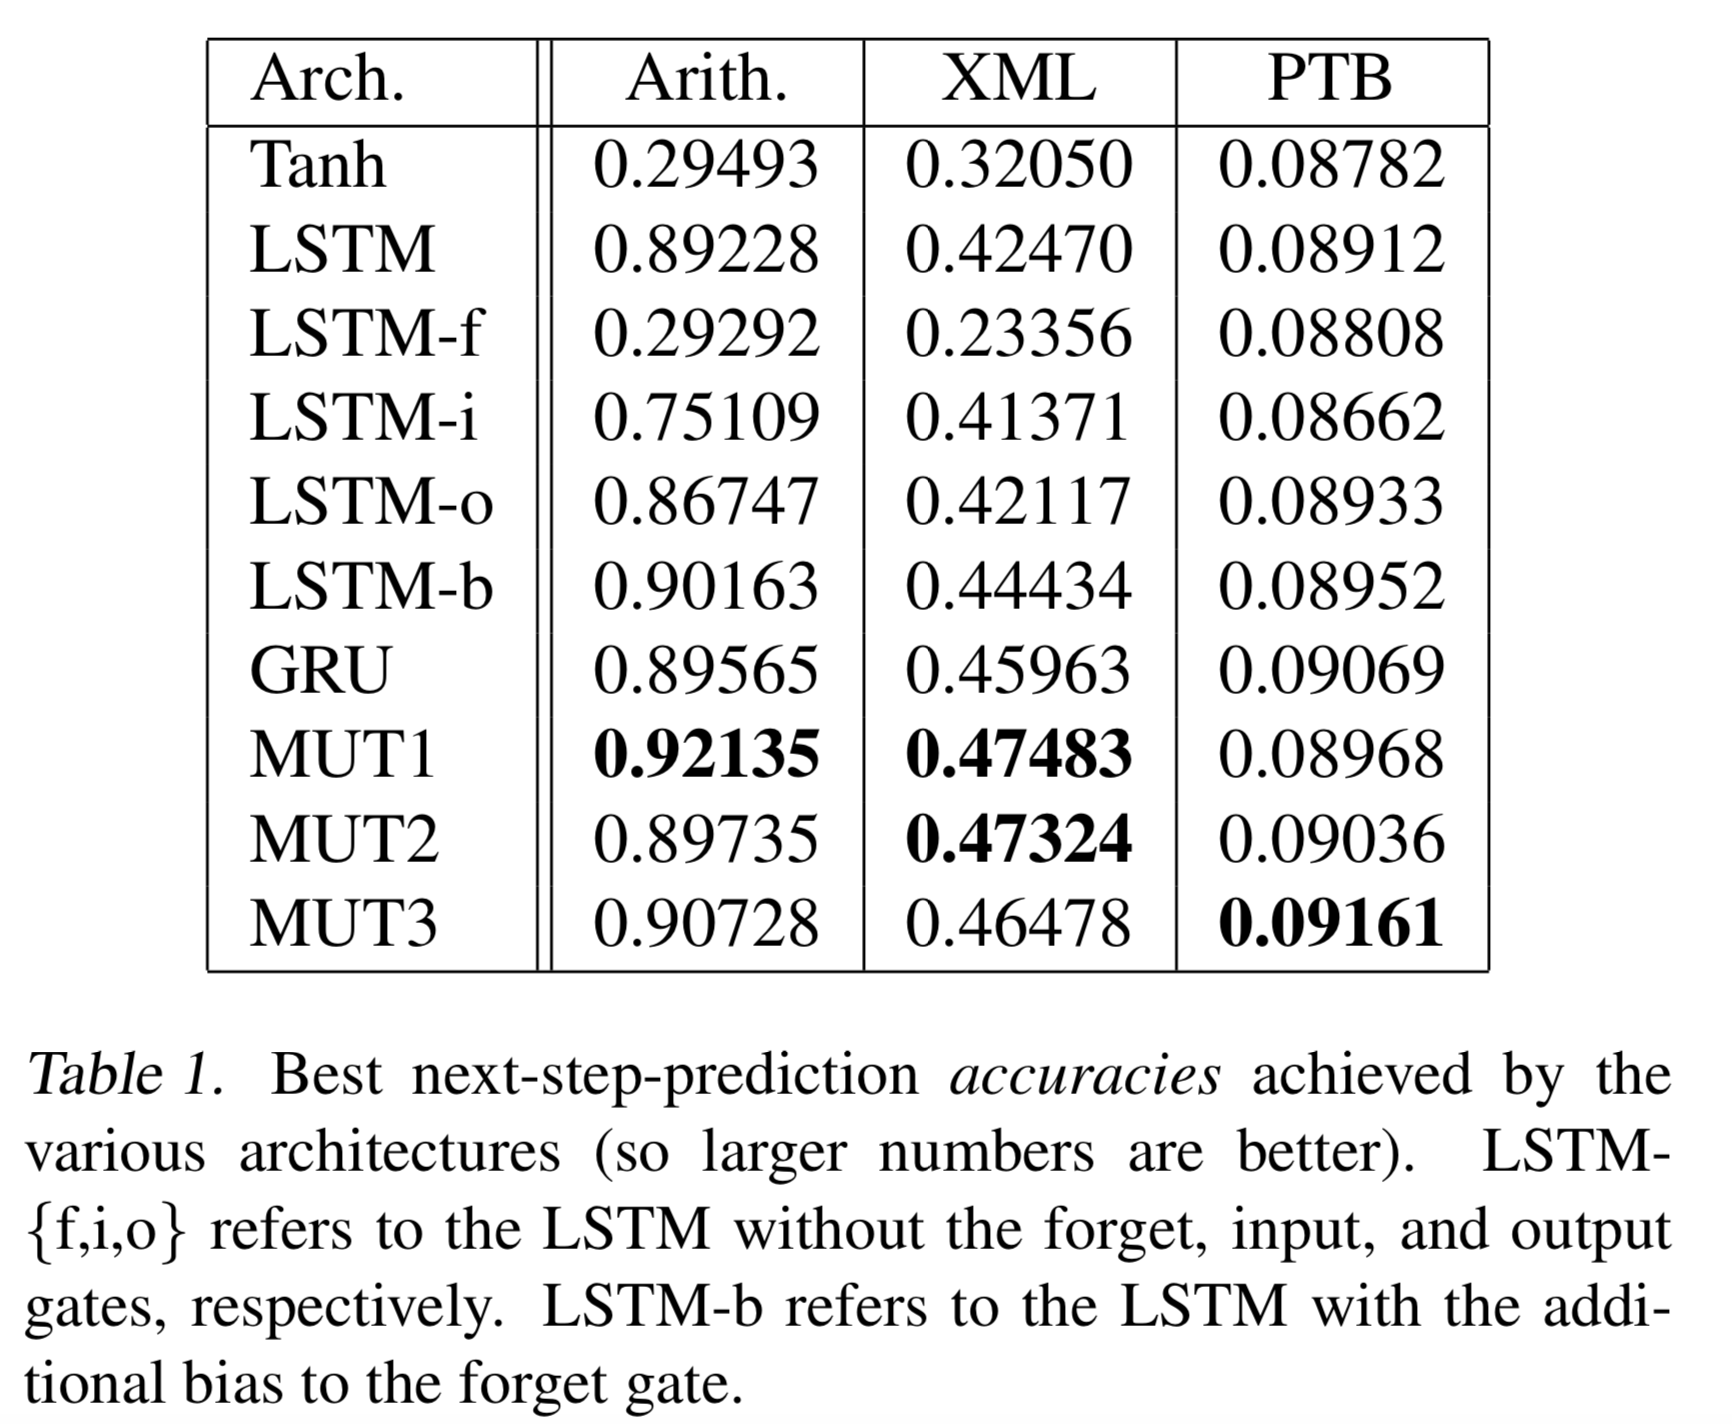

In [145]:
from IPython.display import Image
Image("imagens/14-LSTM-table-J.png")

# Binary Sequence Experiment > GRU

- Are the binary sequences successfully modeled?
    - `window=5`, `n_units=4`
    - art1: LSTM fail miserably, GRU=1.0
    - art2: LSTM=1, GRU=1.0
    - art3: LSTM=0.9, GRU=0.9
    - art4: LSTM=0.6, GRU=1.0
    - art5: LSTM=0.95, GRU=0.95
    
- Wider window
    - `window=10`, `n_units=4`
    - art5: LSTM=0.95, GRU=1.0
    
    
- Activity
    - Different number of units

In [164]:
window=10
Xflatf,Xf,yf,Xflatv,Xv,yv,Xflatt,Xt,yt = data_setup(art5,window)

model_gru = Sequential()

model_gru.add(GRU(units = n_units, input_shape = (1,window)))
model_gru.add(Dense(units = 1,activation='sigmoid')) 

model_gru.compile(loss = 'binary_crossentropy', 
                  optimizer = 'RMSprop', 
                  metrics = ['accuracy'])
  
history = model_gru.fit(Xf,yf,
  batch_size = batch_size, 
  epochs = total_epochs,
  validation_data=(Xv,yv)
)

print("GRU Accuracy =",model_gru.evaluate(Xt,yt)[1])

Epoch 1/5
15989/15989 [==============================] - 39s 2ms/step - loss: 0.4105 - accuracy: 0.7902 - val_loss: 0.0099 - val_accuracy: 1.0000
Epoch 2/5
15989/15989 [==============================] - 38s 2ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 1.0760e-05 - val_accuracy: 1.0000
Epoch 3/5
15989/15989 [==============================] - 34s 2ms/step - loss: 3.7241e-06 - accuracy: 1.0000 - val_loss: 5.3612e-08 - val_accuracy: 1.0000
Epoch 4/5
15989/15989 [==============================] - 38s 2ms/step - loss: 2.7897e-08 - accuracy: 1.0000 - val_loss: 8.3516e-09 - val_accuracy: 1.0000loss: 2.8
Epoch 5/5
63/63 [==============================] - 1s 1ms/step - loss: 6.1441e-09 - accuracy: 1.0000
GRU Accuracy = 1.0


# Bibliography

**Beginner's Intro to RNN's in R**
(https://www.kaggle.com/rtatman/beginner-s-intro-to-rnn-s-in-r)

**Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow**, 2nd Edition
Aurélien Géron, O'Reilly, 2019

**Illustrated Guide to LSTM’s and GRU’s: A step by step explanation**
(https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)

**An Empirical Exploration of Recurrent Network Architectures**
(http://proceedings.mlr.press/v37/jozefowicz15.pdf)

**Understanding LSTM Networks**
https://colah.github.io/posts/2015-08-Understanding-LSTMs/

**How does LSTM prevent the vanishing gradient problem?**
https://stats.stackexchange.com/questions/185639/how-does-lstm-prevent-the-vanishing-gradient-problem
